# Data Exploration 600A

The purpose of this notebook is to query EE signals with PM in order to study failure rates of the system.
To this end, we query:
1. The sequence of FGC and EE digital signals allows for determining whether it was a spurious trigger. FGC is expected to be first, followed by EE Switches
2. Branch opening can be seen by looking at digital switch state and capacitance voltages for checking whether all expected switches were opened (A and B not Z).


In [3]:
from lhcsmapi.pyedsl.QueryBuilder import QueryBuilder

In [1]:
circuit_type = '600A' 
circuit_name = 'RSD2.A45B2' 
t_start = '2021-02-02 18:07:13.197000000'
t_end = '2021-02-02 18:21:31.620000000'

# PC

In [4]:
source_timestamp_pc_df = QueryBuilder().with_pm() \
    .with_duration(t_start=t_start, t_end=t_end) \
    .with_circuit_type(circuit_type) \
    .with_metadata(circuit_name=circuit_name, system='PC') \
    .event_query().df

source_timestamp_pc_df

source            timestamp
0  RPMBB.UA47.RSD2.A45B2  1612285902220000000

In [5]:
from lhcsmapi.Time import Time
Time.to_string(source_timestamp_pc_df.loc[0, 'timestamp'])

'2021-02-02 18:11:42.220000+01:00'

Text(0,0.5,'Current, [A]')

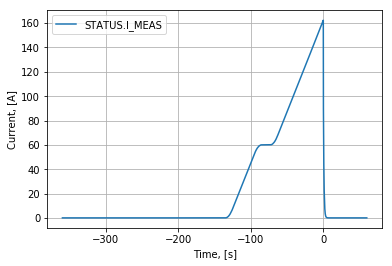

In [8]:
timestamp_fgc = source_timestamp_pc_df.loc[0, 'timestamp']

i_meas_df = QueryBuilder().with_pm() \
            .with_timestamp(timestamp_fgc) \
            .with_circuit_type(circuit_type) \
            .with_metadata(circuit_name=circuit_name, system='PC', signal=['I_MEAS']) \
            .signal_query() \
            .synchronize_time(timestamp_fgc) \
            .convert_index_to_sec().dfs[0]

ax = i_meas_df.plot(grid=True)
ax.set_xlabel('Time, [s]')
ax.set_ylabel('Current, [A]')

# EE

In [9]:
source_timestamp_ee_df = QueryBuilder().with_pm() \
    .with_duration(t_start=t_start, t_end=t_end) \
    .with_circuit_type(circuit_type) \
    .with_metadata(circuit_name=circuit_name, system='EE') \
    .event_query().df

source_timestamp_ee_df

source            timestamp
0  UA47.RSD2.A45B2  1612285902212000000

In [10]:
Time.to_string(source_timestamp_ee_df.loc[0, 'timestamp'])

'2021-02-02 18:11:42.212000+01:00'

In [12]:
(source_timestamp_ee_df.loc[0, 'timestamp'] - source_timestamp_pc_df.loc[0, 'timestamp'])*1e-9 # <= 0.1

-0.008

- Query Logic Signals

In [14]:
from lhcsmapi.metadata.SignalMetadata import SignalMetadata

In [15]:
timestamp_ee = source_timestamp_ee_df.loc[0, 'timestamp']
ee_pm_signal_names = SignalMetadata.get_variable_names(circuit_type, circuit_name, 'EE', 'PM', timestamp_query=timestamp_ee)
ee_pm_signal_names

['ST_CLOS_FAIL_0',
 'ST_CLOS_FAIL_1',
 'ST_FPA_REC_0',
 'ST_FPA_REC_1',
 'ST_MAINS_FAIL',
 'ST_REMOTE',
 'ST_SNUBB_FAIL',
 'ST_SPUR_OPEN_0',
 'ST_SPUR_OPEN_1',
 'ST_SUM_FAULT_FAIL_0',
 'ST_SUM_FAULT_FAIL_1',
 'ST_SW_A_OPEN',
 'ST_SW_B_OPEN',
 'ST_SW_OPNFLR_0',
 'ST_SW_OPNFLR_1',
 'ST_SW_OP_WNG_0',
 'ST_SW_OP_WNG_1',
 'ST_SW_Z_OPEN',
 'ST_SYST_FAIL_0',
 'ST_SYST_FAIL_1',
 'ST_SYST_ST_CLOSED_0',
 'ST_SYST_ST_CLOSED_1',
 'ST_TEMP_EQRES_HIGH',
 'ST_TEMP_RES_HIGH',
 'ST_TST_SOF_MODE_0',
 'ST_TST_SOF_MODE_1',
 'ST_UCAP_A_LOW',
 'ST_UCAP_B_LOW',
 'ST_UCAP_Z_LOW',
 'ST_VOLT_RES_HIGH',
 'U_CAP_A',
 'U_CAP_B',
 'U_CAP_Z',
 'U_DUMP_RES']

In [16]:
ee_pm_logic_signal_names = [ee_pm_signal_name for ee_pm_signal_name in ee_pm_signal_names if 'ST_' in ee_pm_signal_name]
len(ee_pm_logic_signal_names)

30

In [17]:
st_dfs = QueryBuilder().with_pm() \
    .with_timestamp(timestamp_ee) \
    .with_circuit_type(circuit_type) \
    .with_metadata(circuit_name=circuit_name, system='EE', signal=ee_pm_logic_signal_names) \
    .signal_query() \
    .synchronize_time(timestamp_ee) \
    .convert_index_to_sec().dfs

/eos/project/l/lhcsm/venv/lhcsmapi/pyedsl/dbsignal/post_mortem/PmDbRequest.py:165: UserWarning: Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMSN600&source=UA47.RSD2.A45B2&timestampInNanos=1612285902212000000&signal=circ.DQEMC.UA47.RSD2.A45B2:ST_SNUBB_FAIL
  warnings.warn(warning)
/eos/project/l/lhcsm/venv/lhcsmapi/pyedsl/dbsignal/post_mortem/PmDbRequest.py:165: UserWarning: Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMSN600&source=UA47.RSD2.A45B2&timestampInNanos=1612285902212000000&signal=circ.DQEMC.UA47.RSD2.A45B2:ST_SUM_FAULT_FAIL_0
  warnings.warn(warning)
/eos/project/l/lhcsm/venv/lhcsmapi/pyedsl/dbsignal/post_mortem/PmDbRequest.py:165: UserWarning: Querying Post Mortem failed using the following query: http://pm-rest.cern.ch/v2/pmdata/signal?system=QPS&className=DQAMSN600&source=UA47.RSD2.A45B2&timestampInNanos=1612285902212000000&si

<IPython.core.display.Javascript object>


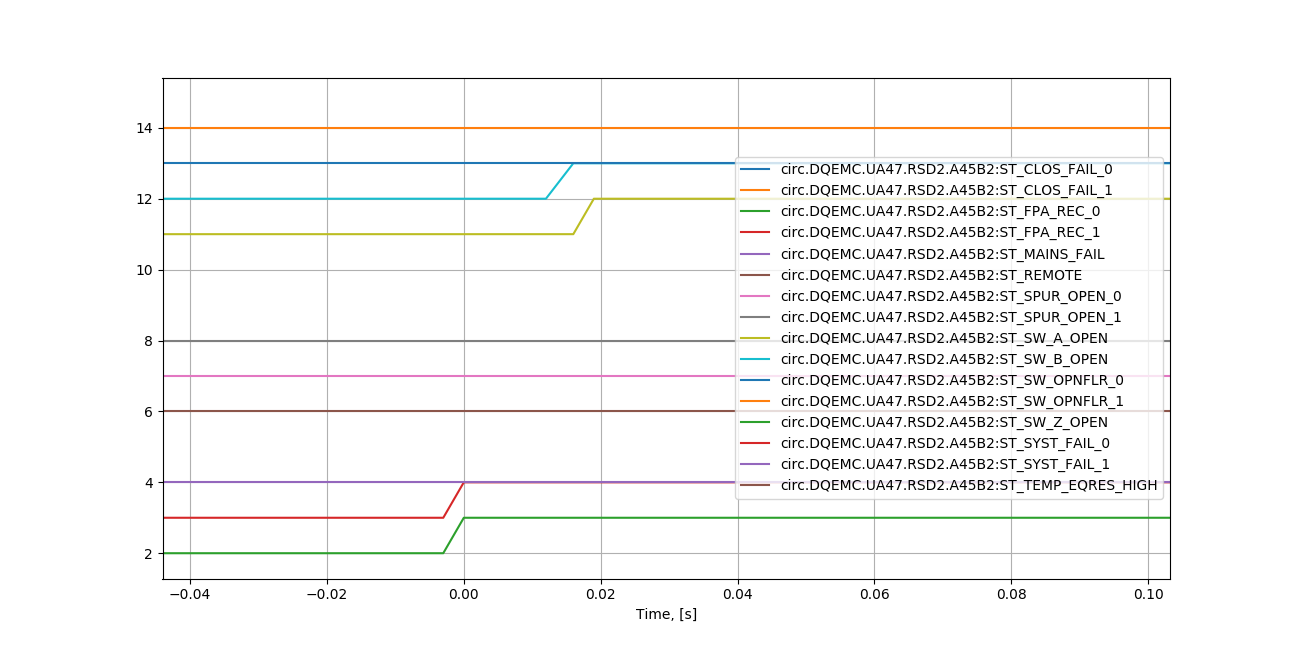

In [22]:
% matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,6.5))

for index, st_df in enumerate(st_dfs):
    if not st_df.empty:
        st_df.astype(int).add(index).plot(ax=ax, grid=True)
ax.legend(loc='right');
ax.set_xlabel('Time, [s]');

- Query Capacitor Voltages

In [23]:
u_cap_dfs = QueryBuilder().with_pm() \
    .with_timestamp(timestamp_ee) \
    .with_circuit_type(circuit_type) \
    .with_metadata(circuit_name=circuit_name, system='EE', signal=['U_CAP_A', 'U_CAP_B', 'U_CAP_Z',]) \
    .signal_query() \
    .synchronize_time(timestamp_ee) \
    .convert_index_to_sec().dfs

<IPython.core.display.Javascript object>


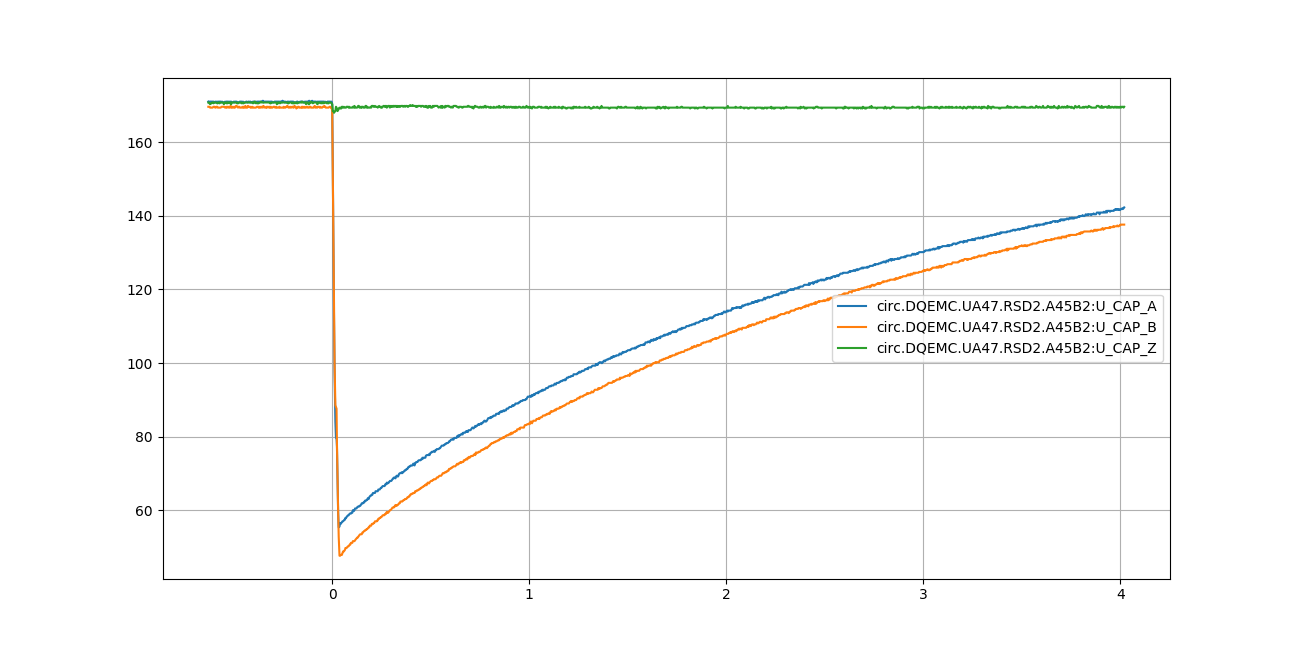

In [24]:
fig, ax = plt.subplots(figsize=(13, 6.5))

for u_cap_df in u_cap_dfs:
    if not u_cap_df.empty:
        u_cap_df.plot(ax=ax, grid=True)
ax.legend(loc='right');

# Feature Engineering

In [25]:
import sys
sys.path

['',
 '/cvmfs/projects.cern.ch/cryogenics/hepak/LCG_95apython3_nxcals',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3_nxcals/x86_64-centos7-gcc7-opt/lib',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3_nxcals/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages',
 '/eos/project/l/lhcsm/venv',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-54b64/x86_64-centos7-gcc7-opt/lib/python36.zip',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-54b64/x86_64-centos7-gcc7-opt/lib/python3.6',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-54b64/x86_64-centos7-gcc7-opt/lib/python3.6/lib-dynload',
 '/eos/user/m/mmacieje/.local/lib/python3.6/site-packages',
 '/cvmfs/sft.cern.ch/lcg/releases/Python/3.6.5-54b64/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3_nxcals/x86_64-centos7-gcc7-opt/lib/python3.6/site-packages/IPython/extensions',
 '/scratch/mmacieje/.ipython']

# Data Collection

In [ ]:
# Long running query

# for t_start in time_range
    # find ee_events from t_start to t_start+24
    
    # for each event in ee_events:
        # find pc_events from timestamp_pc -100 ms to timestamp_pc +100 ms 
        # if there is an event and PC current is nonzero, keep PC and EE timestamps

In [ ]:
# for EE timestamp in EE timestamps:
    # query digital and analog signals
    # compute features
    # store features